### Importing the required libarires

In [ ]:
import torch
from datasets import load_dataset
from tqdm import tqdm
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, SequentialSampler
from sklearn.metrics import matthews_corrcoef
from transformers import (AdamW,T5ForConditionalGeneration,T5Tokenizer,get_linear_schedule_with_warmup)

###  Importing the required libarires

In [6]:
dataset = load_dataset('glue', 'mnli')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Found cached dataset glue (C:/Users/NIT/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/5 [00:00<?, ?it/s]

device(type='cuda')

### Loading the tokenizer and pre-trained model

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base")
model.to(device)

### Forming the train, validaton and test loaders

In [31]:
def getDataLoader(input):
    inputs = ["mnli premise: " + doc1 + " hypothesis: "+ doc2 for doc1, doc2 in zip(input['premise'], input['hypothesis'])]
    #tokenized_inputs = tokenizer.batch_encode_plus(inputs, max_length = 256, pad_to_max_length=True, return_tensors = "pt")
    tokenized_inputs = tokenizer(inputs, padding = True,  truncation=True, return_tensors="pt")
    source_ids = tokenized_inputs['input_ids']
    source_mask = tokenized_inputs['attention_mask']
    
    targets = ['neutral' if label == 1 else 'entailment' if label == 0 else 'contradiction' for label in input['label']]
    #tokenized_outputs = tokenizer.batch_encode_plus(targets, max_length = 32, pad_to_max_length=True, return_tensors = "pt")
    tokenized_outputs = tokenizer(targets, padding = True, return_tensors="pt")
    target_ids = tokenized_outputs['input_ids']
    target_mask = tokenized_outputs['attention_mask']

    # Create a TensorDataset
    batch_size = 8
    data = TensorDataset(source_ids, source_mask, target_ids, target_mask)

    # Create a data loader
    sampler = SequentialSampler(data)
    return DataLoader(data, sampler = sampler, batch_size=batch_size)

train_dataloader = getDataLoader(dataset['train'])
validation_dataloader = getDataLoader(dataset['validation_matched'])
testm_dataloader = getDataLoader(dataset['test_matched'])
testmm_dataloader = getDataLoader(dataset['test_mismatched'])

In [12]:
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [
            p
            for n, p in model.named_parameters()
            if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
    {
        "params": [
            p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]
optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-4,
    eps=1e-8,
)


num_epochs = 2
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

### Fine-tuning T5

In [13]:
from tqdm import tqdm
best_accuracy = 0
for epoch in range(num_epochs):
    
    model.train()
    
    total_loss = 0
    for batch in tqdm(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        source_ids, source_mask, lm_labels, target_mask = batch
        lm_labels[lm_labels[:, :] == tokenizer.pad_token_id] = -100

        optimizer.zero_grad()

        outputs = model(
            input_ids=source_ids,
            attention_mask=source_mask,
            labels = lm_labels,
            decoder_attention_mask=target_mask
        )
        
        loss = outputs[0]
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
        scheduler.step()
    
    # Compute the average loss for the epoch
    avg_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch+1}/{num_epochs} - loss: {avg_loss:.4f}')
    
    # Evaluate the model on the validation set
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in tqdm(validation_dataloader):
            batch = tuple(t.to(device) for t in batch)
            source_ids, source_mask, lm_labels, target_mask = batch
            outs = model.generate(input_ids=source_ids, 
                                  attention_mask=source_mask,
                                  max_length=3)
            predicted_labels = [tokenizer.decode(output, skip_special_tokens=True) for output in outs]
            binary_labels = [1 if label == 'neutral' else 2 if label == 'contradiction' else 0 for label in predicted_labels]
            predictions.extend(binary_labels)
            
    total_correct  = 0
    for i in range(len(predictions)):
        if predictions[i]==dataset['validation_matched'][i]['label']:
            total_correct += 1

    accuracy = total_correct/len(dataset['validation_matched'])
    print(f'Epoch {epoch+1}/{num_epochs} - validation accuracy: {accuracy:.4f}')
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        model.save_pretrained("t5-mnli")

100%|██████████████████████████████████████████████████████████████████████████| 49088/49088 [7:23:19<00:00,  1.85it/s]


Epoch 1/2 - loss: 0.1661


100%|██████████████████████████████████████████████████████████████████████████████| 1227/1227 [02:39<00:00,  7.67it/s]


Epoch 1/2 - validation accuracy: 0.8404


100%|██████████████████████████████████████████████████████████████████████████| 49088/49088 [7:24:35<00:00,  1.84it/s]


Epoch 2/2 - loss: 0.1016


100%|██████████████████████████████████████████████████████████████████████████████| 1227/1227 [02:36<00:00,  7.84it/s]


Epoch 2/2 - validation accuracy: 0.8567


In [ ]:
fineTunedModel = T5ForConditionalGeneration.from_pretrained("t5-mnli")
fineTunedModel.to(device)

In [3]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
tokenizer = AutoTokenizer.from_pretrained("PavanNeerudu/t5-base-finetuned-mnli")
model = AutoModelForSeq2SeqLM.from_pretrained("PavanNeerudu/t5-base-finetuned-mnli")
model.cuda()
print('Loaded Model and tokenizer')

C:\Users\NIT\AppData\Roaming\Python\Python39\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\NIT\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Loaded Model and tokenizer


In [33]:
ax_dataset = load_dataset('glue', 'ax')
testax_dataloader = getDataLoader(ax_dataset['test'])

Found cached dataset glue (C:/Users/NIT/.cache/huggingface/datasets/glue/ax/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/1 [00:00<?, ?it/s]

### Obtaining hidden states averaged over all the tokens to get a single representation of 768 tokens¶

In [38]:
def getHiddenStates(currModel, dataloader):
    currModel.eval()
    totalHiddenStates = [0]*13
    flag = True
    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch = tuple(t.to(device) for t in batch)
            
            source_ids, source_mask, lm_labels, target_mask = batch
            outputs = currModel(input_ids=source_ids,
                            attention_mask=source_mask,
                            labels = lm_labels,
                            decoder_attention_mask=target_mask, 
                            output_hidden_states = True, 
                            return_dict=True)

            hidden_states = outputs.encoder_hidden_states
         
            if flag == True:
                for i in range(len(hidden_states)):
                    totalHiddenStates[i] = hidden_states[i].to("cpu").mean(dim = 1)
                flag = False
            else:
                for i in range(len(hidden_states)):
                    temp = hidden_states[i].to("cpu").mean(dim = 1)
                    totalHiddenStates[i] = torch.cat((totalHiddenStates[i], temp), 0)   
        return totalHiddenStates   


In [26]:
hiddenStates = getHiddenStates(model, testm_dataloader)
preTrainedHiddenStates = torch.stack(hiddenStates, dim = 0)
torch.save(preTrainedHiddenStates, 'preTrainedHiddenStates_MNLI-m.pt')
print(preTrainedHiddenStates.shape)

hiddenStates = getHiddenStates(fineTunedModel, testm_dataloader)
fineTunedHiddenStates = torch.stack(hiddenStates, dim = 0)
torch.save(fineTunedHiddenStates, 'fineTunedHiddenStates_MNLI-m.pt')
print(fineTunedHiddenStates.shape)

100%|██████████████████████████████████████████████████████████████████████████████| 1225/1225 [03:24<00:00,  6.00it/s]


torch.Size([13, 9796, 768])


100%|██████████████████████████████████████████████████████████████████████████████| 1225/1225 [03:29<00:00,  5.84it/s]


torch.Size([13, 9796, 768])


In [42]:
hiddenStates = getHiddenStates(model, testmm_dataloader)
preTrainedHiddenStates = torch.stack(hiddenStates, dim = 0)
torch.save(preTrainedHiddenStates, 'preTrainedHiddenStates_MNLI-mm.pt')
print(preTrainedHiddenStates.shape)

hiddenStates = getHiddenStates( fineTunedModel, testmm_dataloader)
fineTunedHiddenStates = torch.stack(hiddenStates, dim = 0)
torch.save(fineTunedHiddenStates, 'fineTunedHiddenStates_MNLI-mm.pt')
print(fineTunedHiddenStates.shape)

100%|██████████████████████████████████████████████████████████████████████████████| 1231/1231 [03:45<00:00,  5.45it/s]


torch.Size([13, 9847, 768])


100%|██████████████████████████████████████████████████████████████████████████████| 1231/1231 [03:48<00:00,  5.39it/s]


torch.Size([13, 9847, 768])


In [39]:
hiddenStates = getHiddenStates(model, testax_dataloader)
preTrainedHiddenStates = torch.stack(hiddenStates, dim = 0)
torch.save(preTrainedHiddenStates, 'preTrainedHiddenStates_AX.pt')
print(preTrainedHiddenStates.shape)

hiddenStates = getHiddenStates( fineTunedModel, testax_dataloader)
fineTunedHiddenStates = torch.stack(hiddenStates, dim = 0)
torch.save(fineTunedHiddenStates, 'fineTunedHiddenStates_AX.pt')
print(fineTunedHiddenStates.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [00:11<00:00, 11.86it/s]


torch.Size([13, 1104, 768])


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [00:11<00:00, 12.18it/s]

torch.Size([13, 1104, 768])


In [40]:
from CKA import CKA, CudaCKA
cuda_cka = CudaCKA(device)

In [41]:
cka_matrix = torch.empty((13, 13))
for i in range(13):
    for j in range(13):
        X = preTrainedHiddenStates[i].to(device)
        Y = fineTunedHiddenStates[j].to(device)
        cka_matrix[i][j] = cuda_cka.linear_CKA(X, Y)
#torch.save(cka_matrix, 'ckaMatrix.pt')
cka_matrix = cka_matrix.numpy()

In [42]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

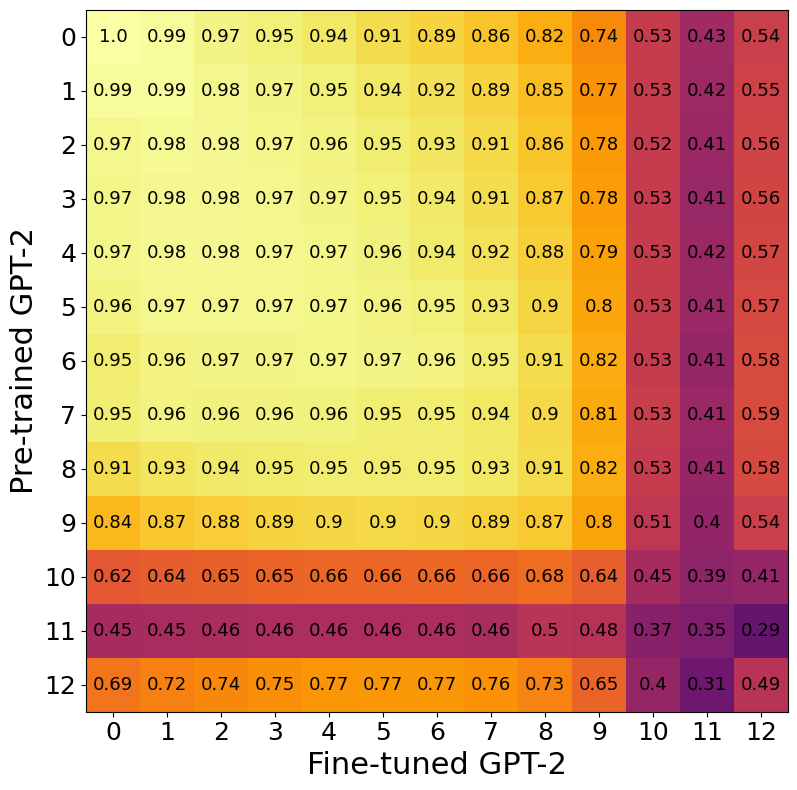

In [43]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cka_matrix, cmap="inferno", vmin=0.0, vmax=1.0)

plt.xticks(np.arange(0,13), fontsize = 18)
plt.yticks(np.arange(0,13), fontsize = 18)

cka_matrix = np.round(cka_matrix, 2)
for x in range(13):
    for y in range(13):
        plt.annotate(cka_matrix[x][y], xy=(y, x), horizontalalignment='center', verticalalignment='center', fontsize=13)

plt.ylabel('Pre-trained GPT-2', fontsize = 22)
plt.xlabel('Fine-tuned GPT-2', fontsize = 22)

#fig.colorbar(im)

plt.tight_layout()

#plt.show()

plt.savefig('AX_preTrained_fineTuned.pdf',  bbox_inches='tight')
plt.savefig('AX_preTrained_fineTuned.jpg',  bbox_inches='tight')

### Calculating STIR

In [44]:
preTrainedHiddenStates = torch.load('./preTrainedHiddenStates_AX.pt').to(device)
fineTunedHiddenStates  = torch.load('./fineTunedHiddenStates_AX.pt').to(device)
print(preTrainedHiddenStates.shape,fineTunedHiddenStates.shape)

torch.Size([13, 1104, 768]) torch.Size([13, 1104, 768])


In [45]:
distinm1 = []
distinm2 = []
for i in range(13):
    distinm1.append(torch.cdist(preTrainedHiddenStates[i], preTrainedHiddenStates[i]))
    distinm2.append(torch.cdist(fineTunedHiddenStates[i], fineTunedHiddenStates[i]))

In [46]:
for i in range(13):
    for j in range(distinm1[0].shape[0]):
        distinm1[i][j][j] = 100000.0
        distinm2[i][j][j] = 100000.0

In [47]:
num_rows = preTrainedHiddenStates.shape[1]
minDistIndForm1 = []
for i in range(13):
    temp = []
    for j in range(num_rows):
        temp.append(torch.argmin(distinm1[i][j]))
    minDistIndForm1.append(temp)
    
minDistIndForm2 = []
for i in range(13):
    temp = []
    for j in range(num_rows):
        temp.append(torch.argmin(distinm2[i][j]))
    minDistIndForm2.append(temp)

In [48]:
from CKA import CKA, CudaCKA
cuda_cka = CudaCKA(device)

In [49]:
import random
def calculate(noOfSamples, noOfTimes):
    STIRm2m1 = []
    STIRm1m2 = []
    CKA = []
    for i in range(13):
        stirm2m1 = 0
        stirm1m2 = 0
        cka = 0
        for j in range(noOfTimes):
            num_list = random.sample(range(0, num_rows), noOfSamples)
            X = []
            X_ = []
            Y = []
            Y_ = []
            for k in range(len(num_list)):
                X.append(fineTunedHiddenStates[i][num_list[k]])
                X_.append(fineTunedHiddenStates[i][minDistIndForm1[i][num_list[k]]])
                Y.append(preTrainedHiddenStates[i][num_list[k]])
                Y_.append(preTrainedHiddenStates[i][minDistIndForm2[i][num_list[k]]])
                
            X = torch.stack(X, dim = 0)
            X_ = torch.stack(X_, dim = 0)
            Y = torch.stack(Y, dim = 0)
            Y_ = torch.stack(Y_, dim = 0)
            
            stirm2m1 = stirm2m1 + cuda_cka.linear_CKA(X, X_)
            stirm1m2 = stirm1m2 + cuda_cka.linear_CKA(Y, Y_)
            cka = cka + cuda_cka.linear_CKA(Y, X)
        
        STIRm2m1.append(stirm2m1/noOfTimes)
        STIRm1m2.append(stirm1m2/noOfTimes)
        CKA.append(cka/noOfTimes)
    return STIRm2m1, STIRm1m2, CKA

In [50]:
STIRm2m1, STIRm1m2, CKA = calculate(num_rows//2, 20)

In [51]:
STIRm2m1 = torch.stack(STIRm2m1, dim = 0)
STIRm1m2 = torch.stack(STIRm1m2,dim = 0)
CKA = torch.stack(CKA, dim = 0)

In [52]:
STIRm2m1 = STIRm2m1.to("cpu")
STIRm2m1 = STIRm2m1.numpy()
STIRm1m2 = STIRm1m2.to("cpu")
STIRm1m2 = STIRm1m2.numpy()
CKA = CKA .to("cpu")
CKA = CKA .numpy()

In [ ]:
print('MNLI-Matched')
print('STIRm2m1:', STIRm2m1)
print('STIRm1m2:', STIRm1m2)
print('CKA:', CKA)

In [22]:
import numpy as np
print('STIRm2m1: ', np.round(STIRm2m1, 2))
print('STIRm1m2: ', np.round(STIRm1m2, 2))
print('CKA: ', np.round(CKA, 2))

STIRm2m1:  [0.99 0.94 0.94 0.94 0.93 0.92 0.91 0.87 0.79 0.53 0.17 0.1  0.25]
STIRm1m2:  [0.99 0.92 0.91 0.92 0.93 0.92 0.91 0.89 0.87 0.84 0.64 0.49 0.31]
CKA:  [1.   0.83 0.81 0.82 0.85 0.87 0.87 0.84 0.73 0.45 0.12 0.05 0.24]


In [25]:
print('MNLI-Mismatched')
print('STIRm2m1:', STIRm2m1)
print('STIRm1m2:', STIRm1m2)
print('CKA:', CKA)

MNLI-Mismatched
STIRm2m1: [0.9914021  0.93865263 0.9379679  0.93633693 0.927796   0.91474897
 0.90327597 0.86588    0.7882971  0.6867464  0.3094377  0.10386206
 0.23491323]
STIRm1m2: [0.9914059  0.90872365 0.90435266 0.9118859  0.9154936  0.9123797
 0.9054846  0.8808837  0.85770303 0.83689433 0.7764738  0.5818319
 0.2888867 ]
CKA: [1.         0.79899234 0.7716211  0.79965985 0.8357283  0.85093635
 0.846056   0.82194895 0.72896636 0.518085   0.19669402 0.08129694
 0.22647765]


In [26]:
import numpy as np
print('STIRm2m1: ', np.round(STIRm2m1, 2))
print('STIRm1m2: ', np.round(STIRm1m2, 2))
print('CKA: ', np.round(CKA, 2))

STIRm2m1:  [0.99 0.94 0.94 0.94 0.93 0.91 0.9  0.87 0.79 0.69 0.31 0.1  0.23]
STIRm1m2:  [0.99 0.91 0.9  0.91 0.92 0.91 0.91 0.88 0.86 0.84 0.78 0.58 0.29]
CKA:  [1.   0.8  0.77 0.8  0.84 0.85 0.85 0.82 0.73 0.52 0.2  0.08 0.23]


In [53]:
print('AX')
print('STIRm2m1:', STIRm2m1)
print('STIRm1m2:', STIRm1m2)
print('CKA:', CKA)

AX
STIRm2m1: [1.         0.99979275 0.99946165 0.9993593  0.9993529  0.99909395
 0.9986025  0.9960794  0.9897041  0.9450593  0.7874647  0.7438252
 0.73784435]
STIRm1m2: [1.         0.9998898  0.99968654 0.9995858  0.9996452  0.99949324
 0.9993519  0.9989169  0.99734366 0.9900223  0.9542187  0.89696926
 0.86791736]
CKA: [1.         0.989246   0.97726834 0.9733127  0.9696353  0.9642253
 0.96213764 0.9354291  0.907176   0.7982872  0.45100448 0.3673126
 0.49035645]


In [54]:
import numpy as np
print('STIRm2m1: ', np.round(STIRm2m1, 2))
print('STIRm1m2: ', np.round(STIRm1m2, 2))
print('CKA: ', np.round(CKA, 2))

STIRm2m1:  [1.   1.   1.   1.   1.   1.   1.   1.   0.99 0.95 0.79 0.74 0.74]
STIRm1m2:  [1.   1.   1.   1.   1.   1.   1.   1.   1.   0.99 0.95 0.9  0.87]
CKA:  [1.   0.99 0.98 0.97 0.97 0.96 0.96 0.94 0.91 0.8  0.45 0.37 0.49]


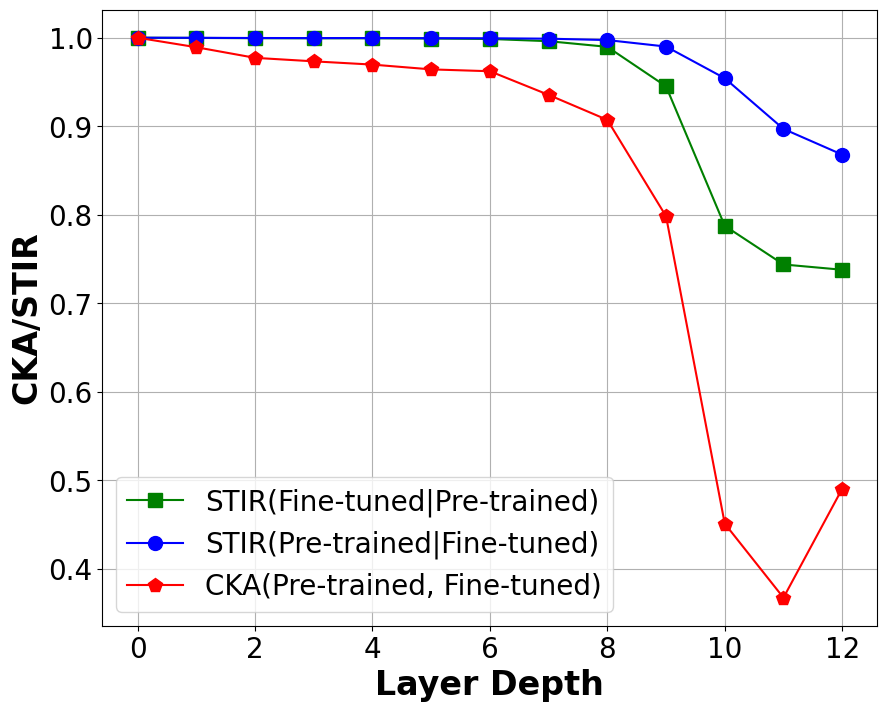

In [55]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.arange(13)
plt.rcParams["figure.figsize"] = [10,8]

series = np.array(STIRm2m1)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='s', markersize=10, color='green')

series = np.array(STIRm1m2)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='o', markersize=10, color='blue')

series = np.array(CKA)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='p', markersize=10, color='red')

plt.legend(['STIR(Fine-tuned|Pre-trained)', 'STIR(Pre-trained|Fine-tuned)', 'CKA(Pre-trained, Fine-tuned)'], fontsize=20)
plt.xlabel('Layer Depth', fontsize = 24, fontweight = 'bold')
plt.ylabel('CKA/STIR', fontsize = 24, fontweight ='bold')

plt.grid(True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.tight_layout()
#plt.show()
plt.savefig('AX CKA STIR.pdf', bbox_inches='tight')
plt.savefig('AX CKA STIR.jpg', bbox_inches='tight')

In [13]:
def test(dataloader):
    predictions = []
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch = tuple(t.to(device) for t in batch)
            source_ids, source_mask, lm_labels, target_mask = batch
            outs = model.generate(input_ids=source_ids, 
                                        attention_mask=source_mask, 
                                        max_length=10)

            predicted_labels = [tokenizer.decode(output, skip_special_tokens=True) for output in outs]
            #binary_labels = [1 if label == 'neutral' else 2 if label == 'contradiction' else 0 for label in predicted_labels]
            predictions.extend(predicted_labels)
    return predictions

In [14]:
import pandas as pd
predictions = test(testm_dataloader)
filename = '../Original/MNLI-m.tsv'
result = pd.DataFrame(predictions, columns=['prediction'])
result.insert(0, 'index', range(0, len(result)))
result.to_csv(filename, sep='\t', index=False)

100%|██████████████████████████████████████████████████████████████████████████████| 1225/1225 [03:50<00:00,  5.30it/s]


In [15]:
import pandas as pd
predictions = test(testmm_dataloader)
filename = '../Original/MNLI-mm.tsv'
result = pd.DataFrame(predictions, columns=['prediction'])
result.insert(0, 'index', range(0, len(result)))
result.to_csv(filename, sep='\t', index=False)

100%|██████████████████████████████████████████████████████████████████████████████| 1231/1231 [04:06<00:00,  4.99it/s]


In [16]:
predictions = test(testax_dataloader)
filename = '../Original/AX.tsv'
result = pd.DataFrame(predictions, columns=['prediction'])
result.insert(0, 'index', range(0, len(result)))
result.to_csv(filename, sep='\t', index=False)

100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [00:21<00:00,  6.28it/s]


In [42]:
def getModifiedDataLoader(tpremise, thypothesis):
    inputs = ["mnli premise: " + doc1 + " hypothesis: "+ doc2 for doc1, doc2 in zip(tpremise, thypothesis)]
    tokenized_inputs = tokenizer(inputs, padding = True, truncation = True, return_tensors="pt")
    source_ids = tokenized_inputs['input_ids']
    source_mask = tokenized_inputs['attention_mask']

    # Create a TensorDataset
    batch_size = 8
    data = TensorDataset(source_ids, source_mask)

    # Create a data loader
    sampler = SequentialSampler(data)
    return DataLoader(data, sampler = sampler, batch_size=batch_size)

def test2(dataloader):
    predictions = []
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch = tuple(t.to(device) for t in batch)
            source_ids, source_mask = batch
            outs = model.generate(input_ids=source_ids, 
                                        attention_mask=source_mask, 
                                        max_length=5)

            predicted_labels = [tokenizer.decode(output, skip_special_tokens=True) for output in outs]
            #binary_labels = [1 if label == 'neutral' else 2 if label == 'contradiction' else 0 for label in predicted_labels]
            predictions.extend(predicted_labels)
    return predictions

test_dataloader = getModifiedDataLoader(testm_premise, testm_hypothesis)
predictions = test2(test_dataloader)
filename = '../bias/MNLI-m.tsv'
result = pd.DataFrame(predictions, columns=['prediction'])
result.insert(0, 'index', range(0, len(result)))
result.to_csv(filename, sep='\t', index=False)

test_dataloader = getModifiedDataLoader(testmm_premise, testmm_hypothesis)
predictions = test2(test_dataloader)
filename = '../bias/MNLI-mm.tsv'
result = pd.DataFrame(predictions, columns=['prediction'])
result.insert(0, 'index', range(0, len(result)))
result.to_csv(filename, sep='\t', index=False)

test_dataloader = getModifiedDataLoader(testax_premise, testax_hypothesis)
predictions = test2(test_dataloader)
filename = '../bias/AX.tsv'
result = pd.DataFrame(predictions, columns=['prediction'])
result.insert(0, 'index', range(0, len(result)))
result.to_csv(filename, sep='\t', index=False)

100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [00:15<00:00,  8.83it/s]


### Text-perturbations

In [27]:
testm_premise = [sentence.split(" ", 1)[1] if " " in sentence else sentence for sentence in dataset['test_matched']['premise']]
testm_hypothesis = [sentence.split(" ", 1)[1] if " " in sentence else sentence for sentence in dataset['test_matched']['hypothesis']]
testmm_premise = [sentence.split(" ", 1)[1] if " " in sentence else sentence for sentence in dataset['test_mismatched']['premise']]
testmm_hypothesis = [sentence.split(" ", 1)[1] if " " in sentence else sentence for sentence in dataset['test_mismatched']['hypothesis']]
testax_premise = [sentence.split(" ", 1)[1] if " " in sentence else sentence for sentence in ax_dataset['test']['premise']]
testax_hypothesis = [sentence.split(" ", 1)[1] if " " in sentence else sentence for sentence in ax_dataset['test']['hypothesis']]

In [29]:
testm_premise = [sentence.rsplit(" ", 1)[0] + sentence[-1] for sentence in dataset['test_matched']['premise']]
testm_hypothesis = [sentence.rsplit(" ", 1)[0] + sentence[-1] for sentence in dataset['test_matched']['hypothesis']]
testmm_premise = [sentence.rsplit(" ", 1)[0] + sentence[-1] for sentence in dataset['test_mismatched']['premise']]
testmm_hypothesis = [sentence.rsplit(" ", 1)[0] + sentence[-1] for sentence in dataset['test_mismatched']['hypothesis']]
testax_premise = [sentence.rsplit(" ", 1)[0] + sentence[-1] for sentence in ax_dataset['test']['premise']]
testax_hypothesis = [sentence.rsplit(" ", 1)[0] + sentence[-1] for sentence in ax_dataset['test']['hypothesis']]

In [31]:
import nltk
#nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag

def remove_nouns(sentence):
    words = nltk.word_tokenize(sentence)
    tagged_words = pos_tag(words)
    filtered_sentence = [word for word, pos in tagged_words if pos != 'NN' and pos != 'NNP' and pos != 'NNS']
    return ' '.join(filtered_sentence)

testm_premise = [remove_nouns(sentence) for sentence in dataset['test_matched']['premise']]
testmm_premise = [remove_nouns(sentence) for sentence in dataset['test_mismatched']['premise']]
testax_premise = [remove_nouns(sentence) for sentence in ax_dataset['test']['premise']]

testm_hypothesis = [remove_nouns(sentence) for sentence in dataset['test_matched']['hypothesis']]
testmm_hypothesis = [remove_nouns(sentence) for sentence in dataset['test_mismatched']['hypothesis']]
testax_hypothesis = [remove_nouns(sentence) for sentence in ax_dataset['test']['hypothesis']]

In [33]:
def remove_verbs(sentence):
    words = nltk.word_tokenize(sentence)
    tagged_words = pos_tag(words)
    filtered_sentence = [word for word, pos in tagged_words if pos != 'VB' and pos != 'VBD' and pos != 'VBG' and pos != 'VBN' and pos != 'VBP' and pos != 'VBZ']
    return ' '.join(filtered_sentence)

testm_premise = [remove_verbs(sentence) for sentence in dataset['test_matched']['premise']]
testmm_premise = [remove_verbs(sentence) for sentence in dataset['test_mismatched']['premise']]
testax_premise = [remove_verbs(sentence) for sentence in ax_dataset['test']['premise']]

testm_hypothesis = [remove_verbs(sentence) for sentence in dataset['test_matched']['hypothesis']]
testmm_hypothesis = [remove_verbs(sentence) for sentence in dataset['test_mismatched']['hypothesis']]
testax_hypothesis = [remove_verbs(sentence) for sentence in ax_dataset['test']['hypothesis']]

In [35]:
import nltk
import random
from nltk.tokenize import word_tokenize

def random_swap_words(sentence):
    words = word_tokenize(sentence)
    if len(words) >= 2:
        i, j = random.sample(range(len(words)), 2)
        words[i], words[j] = words[j], words[i]
        return " ".join(words)
    else:
        return sentence

testm_premise = [random_swap_words(sentence) for sentence in dataset['test_matched']['premise']]
testmm_premise = [random_swap_words(sentence) for sentence in dataset['test_mismatched']['premise']]
testax_premise = [random_swap_words(sentence) for sentence in ax_dataset['test']['premise']]

testm_hypothesis = [random_swap_words(sentence) for sentence in dataset['test_matched']['hypothesis']]
testmm_hypothesis = [random_swap_words(sentence) for sentence in dataset['test_mismatched']['hypothesis']]
testax_hypothesis = [random_swap_words(sentence) for sentence in ax_dataset['test']['hypothesis']]

In [37]:
import random
import string

def replace_characters(sentence, probability=0.10):
    new_sentence = ""
    for char in sentence:
        if random.random() < probability:
            char = random.choice(string.ascii_letters)
        new_sentence += char
    return new_sentence

testm_premise = [replace_characters(sentence) for sentence in dataset['test_matched']['premise']]
testmm_premise = [replace_characters(sentence) for sentence in dataset['test_mismatched']['premise']]
testax_premise = [replace_characters(sentence) for sentence in ax_dataset['test']['premise']]

testm_hypothesis = [replace_characters(sentence) for sentence in dataset['test_matched']['hypothesis']]
testmm_hypothesis = [replace_characters(sentence) for sentence in dataset['test_mismatched']['hypothesis']]
testax_hypothesis = [replace_characters(sentence) for sentence in ax_dataset['test']['hypothesis']]

In [39]:
import random
from faker import Faker
from typing import List

def add_random_words(sentences: List[str]):
    fake = Faker()
    new_sentences = []
    for sentence in sentences:
        words = sentence.split()
        num_words_to_add = int(len(words) / 5)
        for i in range(num_words_to_add):
            insert_index = random.randint(0, len(words) - 1)
            words.insert(insert_index, fake.word())
        new_sentences.append(" ".join(words))
    return new_sentences

testm_premise = add_random_words(dataset['test_matched']['premise'])
testmm_premise = add_random_words(dataset['test_mismatched']['premise'])
testax_premise = add_random_words(ax_dataset['test']['premise'])

testm_hypothesis = add_random_words(dataset['test_matched']['hypothesis'])
testmm_hypothesis = add_random_words(dataset['test_mismatched']['hypothesis'])
testax_hypothesis = add_random_words(ax_dataset['test']['hypothesis'])

In [41]:
def changeGender(str):
    dictionary = {
    "batman": "batwoman", "batwoman": "batman",
    "boy": "girl", "girl": "boy",
    "boyfriend": "girlfriend", "girlfriend": "boyfriend",
    "father": "mother", "mother": "father",
    "husband": "wife", "wife": "husband",
    "he": "she", "she": "he", "He":"She", "She":"He",
    "his": "her", "her": "his", "His":"Her", "Her":"His",
    "male": "female", "female": "male","him":"her","her":"him",
    "man": "woman", "woman": "man",
    "Mr": "Ms", "Mr": "Ms",
    "sir": "madam", "madam": "sir",
    "son": "daughter", "daughter": "son",
    "uncle": "aunt", "aunt": "uncle",
    }

    str = str + ' ' # Append a space at the en
    temp = ""
    ans = ""

    for i in range(len(str)):
        if str[i] != ' ':
            temp += str[i]
        else:
            if temp in dictionary:
                temp = dictionary[temp]

            ans = ans + temp + ' '
            temp = ""

    return ans

testm_premise = [changeGender(sentence) for sentence in dataset['test_matched']['premise']]
testmm_premise = [changeGender(sentence) for sentence in dataset['test_mismatched']['premise']]
testax_premise = [changeGender(sentence) for sentence in ax_dataset['test']['premise']]

testm_hypothesis = [changeGender(sentence) for sentence in dataset['test_matched']['hypothesis']]
testmm_hypothesis = [changeGender(sentence) for sentence in dataset['test_mismatched']['hypothesis']]
testax_hypothesis = [changeGender(sentence) for sentence in ax_dataset['test']['hypothesis']]